# Rigorous splitting of datasets into train and validation

In this lab we will try our hand at protein structure prediction. Given a few thousands protein sequences, for each of the amino acids in the sequences we will try to predict if in the protein structure they will be part of one of three classes:

* $\alpha$-helix
* $\beta$-sheet
* none of the above
<img src="figures/secondary_structure.png?0">

So the input to our predictor is a protein sequence string such as this one:

```
>APF29063.1 spike protein [Human coronavirus NL63]
MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPTHWFCANQSTSVYSANGFFYIDVGN
HRSAFALHTGYYDVNQYYIYVTNEIGLNASVTLKICKFGINTTFDFLSNSSSSFDCIVNLLFTEQLGAPL
```

for each letter in the sequence, we want to make a classification in the three classes mentioned above.

I have prepared a dataset where all protein sequences have been pre-split into windows of 31 amino acids. We want to predict the class for the amino acid in the center of the window, like so:


predict("MKLFLILLVLPLASCF<font color="red">F</font>TCNSNANLSMLQLG") -> [p(H), p(S), p(C)]

Of course, a neural network will not accept a string input as it is, so we will have to deal with this by converting each letter in our alphabet into an integer. Then, we will use word embeddings to translate the integers into vectors of floating points.


## Data download

First, let's download dataset and other relevant data:

In [ ]:
!wget -v -O data/dataset_sseq_singleseq.pic -L   https://liu.box.com/shared/static/egutdq7rb5q3gaiu0fbjy9csl28ogpo9
!wget -v -O data/trainset_distance_matrix.tsv -L https://liu.box.com/shared/static/xbgslccvlbosodtd585n7nh7s6hpmjoz

Now let's load libraries and plotting functions:

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import h5py
import sys
from keras import Model
from keras.layers import Input, Embedding, Flatten, Dense, Dropout, LSTM, Conv1D
from keras.layers.wrappers import Bidirectional
from keras.utils.io_utils import HDF5Matrix
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt

def plot_loss_acc(history):
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train acc', 'val acc', 'train loss', 'val loss'], loc='upper left')
    plt.show()

Now let's create a function that returns a keras model. Modify the code below to try different architectures:

In [2]:

def get_model(convolutional = False, window=31):# This switches between a convolutional or a recurrent architecture 
    
    embed_size = 16
    bidir_size = 64

    #INPUTS timesteps are columns from the MSA
    inputs = Input(shape=(window,))
    embed = Embedding(21, embed_size, input_length=window, batch_input_shape=(batch, window))(inputs)

    bidir = Bidirectional(LSTM(bidir_size, return_sequences=True), merge_mode='ave')(embed)

    conv = Conv1D(32, 7, activation='relu')(embed)
    conv2 = Conv1D(64, 5, activation='relu')(conv)
    conv3 = Conv1D(128, 3, activation='relu')(conv2)

    if convolutional:
        dense = Dense(32)(Flatten()(conv2))
    else:
        dense = Dense(32)(Flatten()(bidir))

    dense2 = Dense(16)(dense)
    outputs = Dense(3, activation='softmax')(dense2)

    #MODEL
    model_sseq = tf.keras.Model(inputs, outputs)

    print('Compiling the model...')
    model_sseq.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    model_sseq.summary()
    
    return model_sseq

Look at the architecture above:
* What does putting the variable "convolutional" to False mean? What happens to the bidirectional layers when we are using a convolutional architecture?
* Which architecture would be best for this type of dataset in your opinion?
    

In [3]:
def count_steps(target_list_data, batch=None):
    
    n_targets = len(target_list_data)
    
    target_index = 0
    n_steps = 0
    for target in target_list_data:

        try:
            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs_windows/' + target))  # length x max_depth
            #print(X_batch.shape)
        except:
            continue

        length = X_batch.shape[0]
                                             
        n_steps += int(length / batch)
    return n_steps
        
def generate_inputs_window(X, y, target_list_data, batch=None, shuffle=False):

    n_targets = len(target_list_data)
    if shuffle:
        random.shuffle(target_list_data)
    
    target_index = 0
    while 1:
        
        target = target_list_data[target_index]
        target_index += 1
        target_index = target_index % n_targets

        # create numpy arrays of input data
        # and labels, from each line in the file
        try:
            X_batch = X[target]
        except:
            continue

        length = X_batch.shape[0]
                                        # 0...00length00...0, max_depth                    
            
        labels_batch_sseq = y[target]
        
       # print(np.array(X_batch_windows).shape)
        
        for i in range(0, length, batch):
            # length x 1 (sparse, 3 class)
            yield (X_batch[i:i+batch], labels_batch_sseq[i:i+batch])
    

def load_inputs(target_list_data, shuffle=False):

    X = {}
    y = {}
    
    n_targets = len(target_list_data)
    if shuffle:
        random.shuffle(target_list_data)
            
    target_index = 0
    
    #X = np.zeros((0,31))
    #y = np.zeros(0)

    for target_index in range(n_targets):

        target = target_list_data[target_index]

        try:
            X_batch = np.asarray(HDF5Matrix(input_dataset, 'inputs_windows/' + target))  # length x max_depth
        except:
            continue

        length = X_batch.shape[0]
                                        # 0...00length00...0, max_depth                    
        
        X[target] = X_batch
        #y = np.concatenate((y,np.squeeze(np.asarray(HDF5Matrix(input_dataset, 'labels_sseq/' + target)))))
        y[target] = np.squeeze(np.asarray(HDF5Matrix(input_dataset, 'labels_sseq/' + target)))
    return X, y

Let's start by taking the classical approach of randomly splitting the data in a trainset and a validation set (95%/5% by default, but you can change the ratio as you prefer).

In [4]:
import random

input_dataset = 'data/dataset_sseq_singleseq.hdf5'
target_list_path = 'data/train_set'
batch = 32

target_list_file = open(target_list_path)
target_list = target_list_file.readlines()
random.shuffle(target_list)
n_targets = len(target_list)
train_list = target_list[int(n_targets/20):] #95% train
validation_list = target_list[:int(n_targets/20)] #5% validation

validation_steps = count_steps(validation_list, batch)
print("Validation batches:", validation_steps)

Instructions for updating:
Training with HDF5Matrix is not optimized for performance. Instead, we recommend using https://github.com/tensorflow/io to load your HDF5 data into a tf.data Dataset and passing that dataset to Keras.


/home/claudio/anaconda3/envs/nn_dl_python/lib/python3.7/site-packages/tensorflow/python/keras/utils/io_utils.py:89: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


Validation batches: 2604


Now let's load the dataset as a pickle object:

In [5]:
train_test_data = open("data/train_test_set", 'r').readlines()
X,y = load_inputs(train_test_data)

import pickle
pickle.dump((X,y), open("data/dataset_sseq_singleseq.pic", 'wb'))

In [ ]:
import pickle
(X,y) = pickle.load(open("data/dataset_sseq_singleseq.pic",'rb'))

And now, let's train the model a first time (train and validation split randomly):

In [30]:
window = 31
model_sseq = get_model(convolutional=True, window=window) #get a fresh model
hist = model_sseq.fit(generate_inputs_window(X,y,train_list, batch), 
               validation_data=generate_inputs_window(X,y,validation_list, batch), 
               epochs=40, steps_per_epoch=1000, validation_steps=validation_steps, batch_size=batch)


Compiling the model...
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 31, 16)            336       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 25, 32)            3616      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 21, 64)            10304     
_________________________________________________________________
flatten_7 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                43040     
_________________________________________________________________
dense_22 (Dense)             (None, 

1000/1000 [==============================] - 29s 29ms/step - loss: 0.7217 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.7058 - val_sparse_categorical_accuracy: 0.6963
Epoch 38/40
1000/1000 [==============================] - 24s 24ms/step - loss: 0.7081 - sparse_categorical_accuracy: 0.6937 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.6896
Epoch 39/40
1000/1000 [==============================] - 31s 31ms/step - loss: 0.7104 - sparse_categorical_accuracy: 0.6978 - val_loss: 0.7104 - val_sparse_categorical_accuracy: 0.6943
Epoch 40/40
1000/1000 [==============================] - 25s 25ms/step - loss: 0.7150 - sparse_categorical_accuracy: 0.6940 - val_loss: 0.7074 - val_sparse_categorical_accuracy: 0.6927


Let's plot the training curves below:

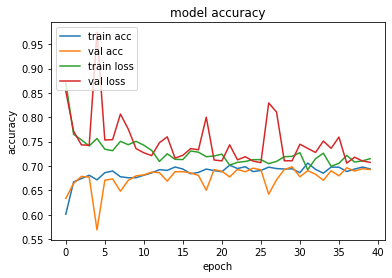

In [31]:
plot_loss_acc(hist)

* What is the best validation performance that you can extract from your Model?
* What would be the best naïve classifier for this dataset? How does the validation performance of your model compare to it?
* What do you think of randomly splitting the dataset this way? Can you think of a better way of doing it? Can you think of a _worse_ day of doing it?

## Splitting the dataset by sequence similarity

I have used HHblits (a software to perform sequence alignments) to find out just how distant the proteins in the dataset are, evolutionarily speaking. This distance goes from 0 (sequences are identical) to 1 (no relationship between the proteins could be detected at all). The distance is basically an inverse measure of how similar the sequences are to each other.

This information is stored in a distance matrix of size NxN, where N is the number of sequences in the dataset. In the code block below I load the distance matrix from the filesystem, then we use the data to perform [linkage clustering](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) and plot a [dendrogram](https://en.wikipedia.org/wiki/Dendrogram) to visualize the clusters.

In the dendrogram below we can see how proteins group together at various distance thresholds.

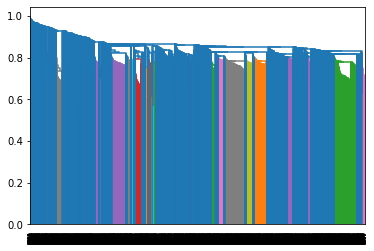

In [38]:
sys.setrecursionlimit(100000) #fixes issue with scipy and recursion limit
distance_matrix = pd.read_csv('data/trainset_distance_matrix.tsv', sep='\t')
dists = squareform(distance_matrix)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, color_threshold=0.8)
plt.show()

Below, we choose a threshold to get our cluster based on the distance threshold t. So we "cut" the dendrogram above at the threshold t, and all the proteins that fall under the same branch at that threshold will be put in the same cluster. Feel free to get a feeling of how clusters are formed/split by varying the threshold below:

In [33]:
cluster_assignments = fcluster(linkage_matrix,criterion='distance', t=0.8)
print(len(cluster_assignments), np.max(cluster_assignments))

6546 2449


Now let's create a training and a validation set based on these clusters in such a way that a cluster of protein is EITHER in train OR in validation. Depending on the threshold we have picked, this could make sure that no proteins in the validation set are too similar to those in the trainset.

In [34]:
target_list_file = open(target_list_path)
target_list = target_list_file.readlines()

train_list_cluster = []
validation_list_cluster = []
validation_size_limit = int(n_targets/20)

for i in range(1,np.max(cluster_assignments)+1):
    index_this_cluster = np.where(cluster_assignments == i)[0]
    if len(validation_list_cluster) < validation_size_limit: #add all elements in this cluster to either validation or train set
        validation_list_cluster += [target_list[element] for element in index_this_cluster]
    else:
        train_list_cluster += [target_list[element] for element in index_this_cluster]

random.shuffle(train_list_cluster)
validation_steps_cluster = count_steps(validation_list_cluster, batch)
print("Validation batches:", validation_steps_cluster)

Validation batches: 4495


Now, let's train a new model with the new datasets and see if we get different results:

In [35]:


model_sseq2 = get_model(convolutional=True, window=window) #get a fresh model

hist2 = model_sseq2.fit(generate_inputs_window(X,y,train_list_cluster, batch), 
               validation_data=generate_inputs_window(X,y,validation_list_cluster, batch), 
               epochs=40, steps_per_epoch=1000, validation_steps=validation_steps_cluster, batch_size=batch)


Compiling the model...
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 31, 16)            336       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 25, 32)            3616      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 21, 64)            10304     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                43040     
_________________________________________________________________
dense_25 (Dense)             (None, 

1000/1000 [==============================] - 24s 24ms/step - loss: 0.7094 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.7247 - val_sparse_categorical_accuracy: 0.6878
Epoch 38/40
1000/1000 [==============================] - 31s 31ms/step - loss: 0.7167 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.7269 - val_sparse_categorical_accuracy: 0.6856
Epoch 39/40
1000/1000 [==============================] - 30s 30ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.7051 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.6892
Epoch 40/40
1000/1000 [==============================] - 27s 27ms/step - loss: 0.7069 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.7405 - val_sparse_categorical_accuracy: 0.6800


Let's plot again the training curves from the first model and compare them to those from the new model. 

What are the differences, if any?

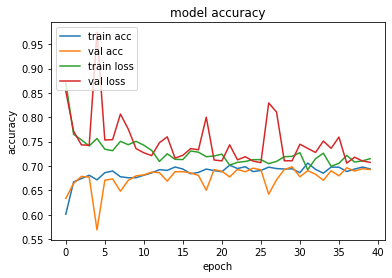

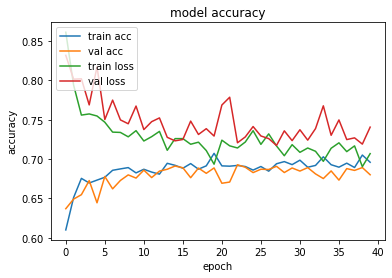

In [36]:
plot_loss_acc(hist)
plot_loss_acc(hist2)

Now let's test the two models on previously unseen data. Which performs best?

In [37]:
test_list = open("data/test_set").readlines()
test_steps = count_steps(test_list, batch)
print("Test steps:", test_steps)
model_sseq.evaluate(generate_inputs_window(X,y,test_list, batch), verbose=1, steps=test_steps)
model_sseq2.evaluate(generate_inputs_window(X,y,test_list, batch), verbose=1, steps=test_steps)

Test steps: 1510
1510/1510 [==============================] - 7s 5ms/step - loss: 0.7846 - sparse_categorical_accuracy: 0.6524


[0.7845718860626221, 0.6523804068565369]

Now let's make things even worse on purpose: whenever a cluster contains more than one sample, let's put half in the training set and half in the validation set. Then let's not shuffle the trainset so that the network sees those samples first.

In [39]:
target_list_file = open(target_list_path)
target_list = target_list_file.readlines()

train_list_bad = []
validation_list_bad = []
validation_size_limit = int(n_targets/20)

for i in range(1,np.max(cluster_assignments)+1):
    index_this_cluster = np.where(cluster_assignments == i)[0]

    if len(index_this_cluster) > 1: #add all elements in this cluster to either validation or train set
        half_elements = int(len(index_this_cluster)/2)
        validation_list_bad += [target_list[element] for element in index_this_cluster[:half_elements]]
        train_list_bad += [target_list[element] for element in index_this_cluster[half_elements:]]
    
validation_steps_bad = count_steps(validation_list_bad, batch)
print("Validation batches:", validation_steps_bad)

Validation batches: 17232


In [40]:
model_sseq3 = get_model(convolutional=True, window=window) #get a fresh model

hist3 = model_sseq3.fit(generate_inputs_window(X,y,train_list_bad, batch), 
               validation_data=generate_inputs_window(X,y,validation_list_bad, batch), 
               epochs=40, steps_per_epoch=1000, validation_steps=validation_steps_bad, batch_size=batch)


Compiling the model...
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 31, 16)            336       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 25, 32)            3616      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 21, 64)            10304     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                43040     
_________________________________________________________________
dense_28 (Dense)             (None, 

1000/1000 [==============================] - 86s 86ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.7331 - val_sparse_categorical_accuracy: 0.6873
Epoch 38/40
1000/1000 [==============================] - 62s 62ms/step - loss: 0.7077 - sparse_categorical_accuracy: 0.6972 - val_loss: 0.7189 - val_sparse_categorical_accuracy: 0.6930
Epoch 39/40
1000/1000 [==============================] - 73s 73ms/step - loss: 0.7174 - sparse_categorical_accuracy: 0.6956 - val_loss: 0.7594 - val_sparse_categorical_accuracy: 0.6708
Epoch 40/40
1000/1000 [==============================] - 77s 77ms/step - loss: 0.6751 - sparse_categorical_accuracy: 0.7177 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.6586


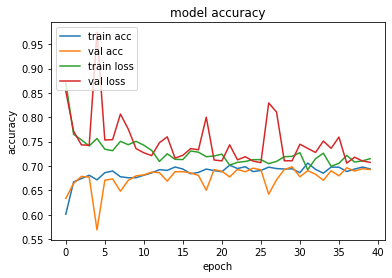

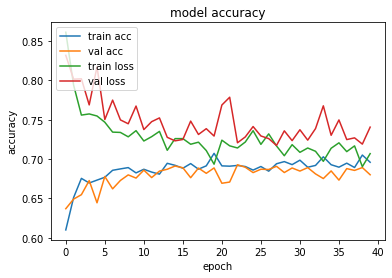

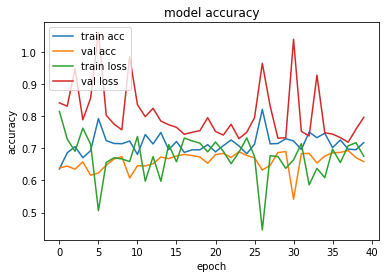

In [41]:
plot_loss_acc(hist)
plot_loss_acc(hist2)
plot_loss_acc(hist3)